In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
normaloperation = pd.read_csv("Normaloperation.csv",header=None)
faultyoperation = pd.read_csv("Faultyoperation.csv",header=None)

#switch rows and columns
normaloperation = normaloperation.T
faultyoperation = faultyoperation.T

In [3]:
normaloperation.shape, faultyoperation.shape

((558, 18), (559, 18))

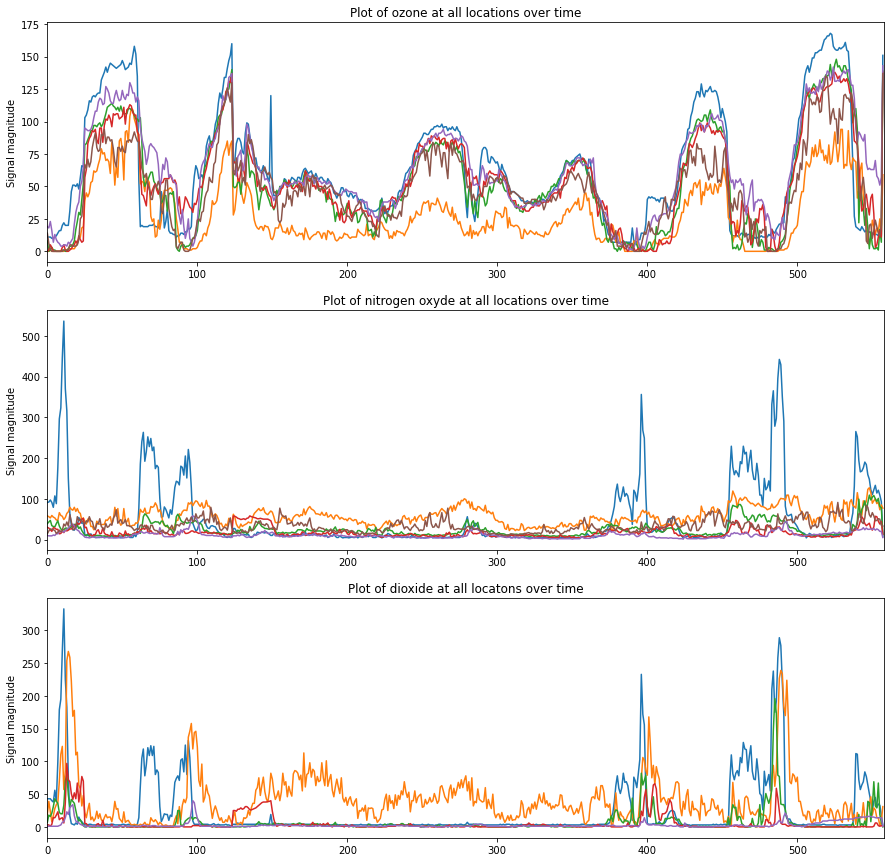

In [4]:
#plot sensor data
fig, axs = plt.subplots(3,1,figsize=(15,15))
axs[0].plot(normaloperation.iloc[:,np.arange(0,17,3)])
axs[0].set_xlim(0,normaloperation.shape[0])
axs[0].set_title("Plot of ozone at all locations over time")
axs[0].set_ylabel('Signal magnitude')

axs[1].plot(normaloperation.iloc[:,np.arange(1,17,3)])
axs[1].set_xlim(0,normaloperation.shape[0])
axs[1].set_title("Plot of nitrogen oxyde at all locations over time")
axs[1].set_ylabel('Signal magnitude')

axs[2].plot(normaloperation.iloc[:,np.arange(2,17,3)])
axs[2].set_xlim(0,normaloperation.shape[0])
axs[2].set_title("Plot of dioxide at all locatons over time")
axs[2].set_ylabel('Signal magnitude')
plt.show()


In [5]:
#center and normalize data
normalized_data = StandardScaler().fit_transform(normaloperation)

In [6]:
normalized_data = pd.DataFrame(normalized_data)

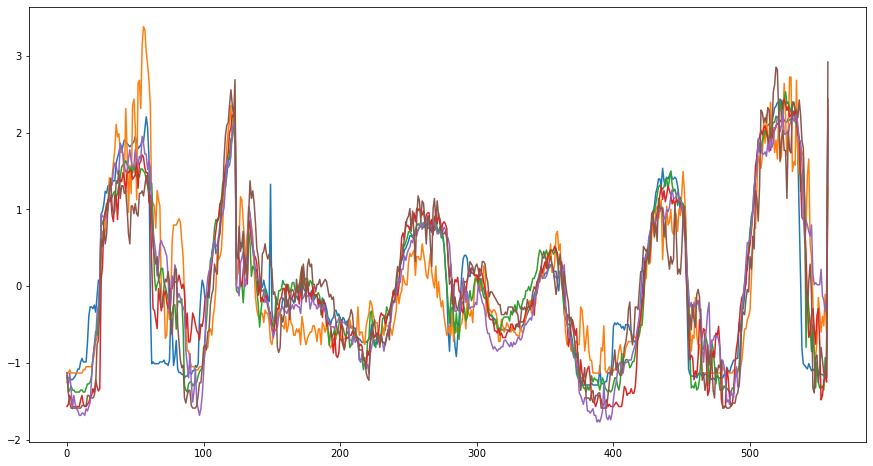

In [7]:
#plot normalized data
plt.figure(figsize=(15,8))
plt.plot(normalized_data[np.arange(0,17,3)])
plt.show()

In [8]:
# calculate the covariance matrix of the normalized data

cov_mat = np.cov(normalized_data,rowvar=False)

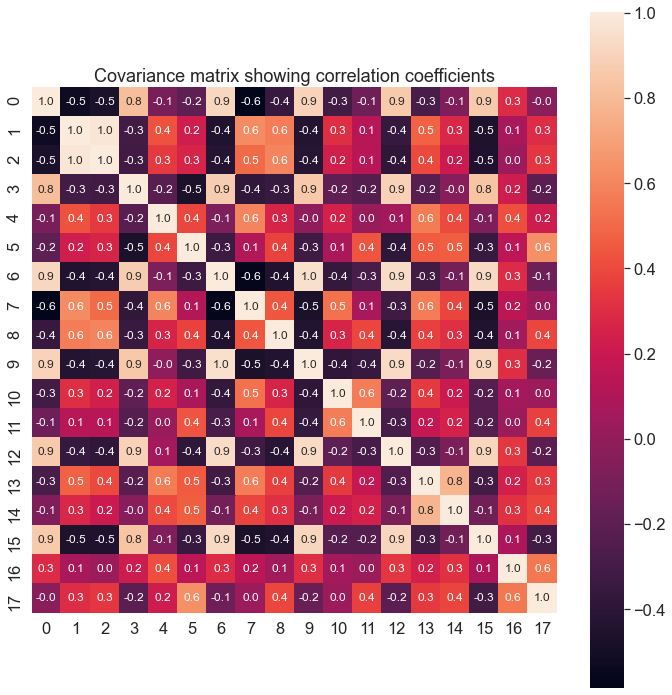

In [9]:
#visualize covariance matrix
import seaborn as sns

plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
hm = sns.heatmap(cov_mat,cbar=True,annot=True,square=True,fmt='.1f',annot_kws={'size':12})
plt.title('Covariance matrix showing correlation coefficients')
plt.tight_layout()
plt.show()

In [10]:
#Calculate Eigenvalues and Eigenvectors of the covariance matrix
eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)

In [11]:
eigen_values.shape,eigen_vectors.shape

((18,), (18, 18))

In [12]:
# Also calculate Eigenvalues and Eigenvectors of covariance matrix using SVD
U, S, VT = np.linalg.svd(cov_mat,full_matrices=0)

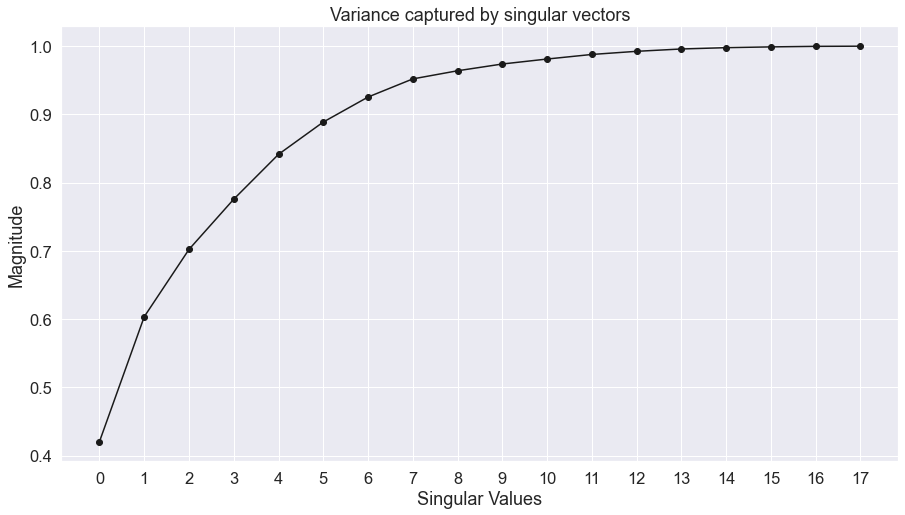

In [13]:
#plot singular values of the dataset
#shows how much variance is captured by singular vectors
plt.figure(figsize=(15,8))
plt.plot(np.cumsum(S)/np.sum(S),'-o',color='k')
plt.xticks(np.arange(0,18,step=1))
plt.xlabel('Singular Values')
plt.ylabel('Magnitude')
plt.title('Variance captured by singular vectors')
plt.show()

In [14]:
#implement PCA using scikit-learn
pca = PCA()
principalcomponents = pca.fit_transform(normalized_data)

In [15]:
principalDf = pd.DataFrame(data=principalcomponents[:,:2],
                           columns=['principal component 1', 'principal component 2'])
principalDf

,principal component 1,principal component 2
0,2.623264,-2.259425
1,3.037931,-1.950453
2,2.811727,-1.973987
3,2.730193,-2.118890
4,3.282635,-1.873138
...,...,...
553,4.227373,1.939709
554,4.724005,2.261557
555,3.175223,1.243902
556,3.249533,0.921323


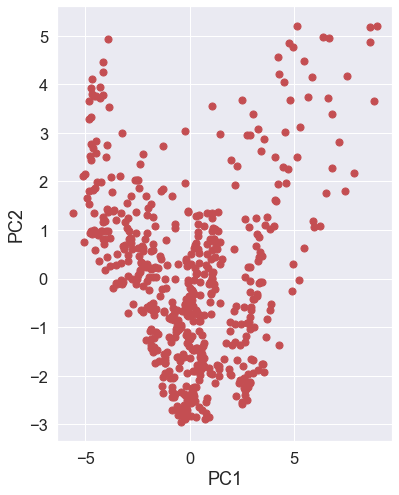

In [16]:
#Visualize 2D projection
fig = plt.figure(figsize=(6,8))
plt.scatter(principalDf['principal component 1'],
            principalDf['principal component 2'],marker='o',color='r',s=50)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


In [17]:
# Build a fault detection algorithm using Mahalanobis distance based on first
# 12 principal components

from sklearn.covariance import EmpiricalCovariance, MinCovDet

robust_covariance = MinCovDet().fit(principalcomponents[:,:12])

# Get the Mahalanobis distance
Mahalanobis_distance = robust_covariance.mahalanobis(principalcomponents[:,:12])

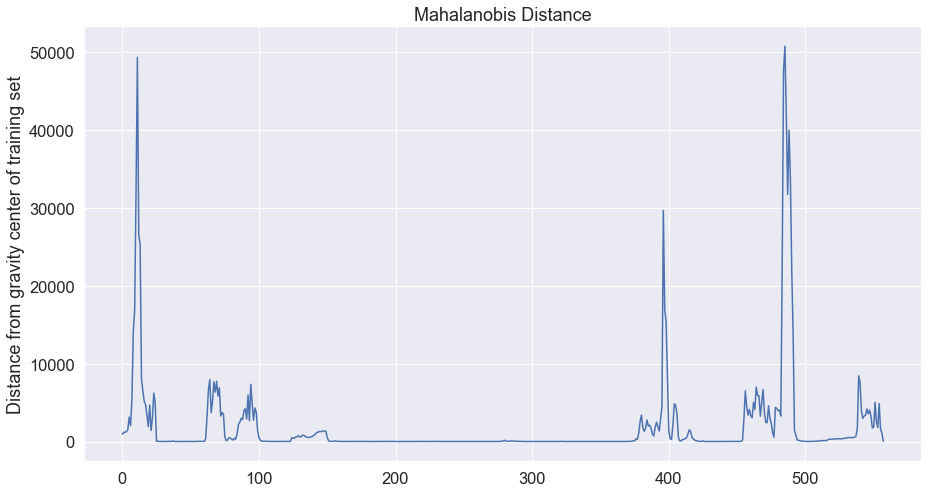

In [18]:
#plot fault detection distance from center threshold
fig = plt.figure(figsize=(15,8))
plt.plot(Mahalanobis_distance)
plt.ylabel('Distance from gravity center of training set')
plt.title('Mahalanobis Distance')
plt.show()

In [19]:
#we assume that the data is gaussian so we put a threshold that enusres that at least 99% 
# of our data will be below this value

threshold_mahalanobis = np.mean(Mahalanobis_distance) + (3 * np.std(Mahalanobis_distance))

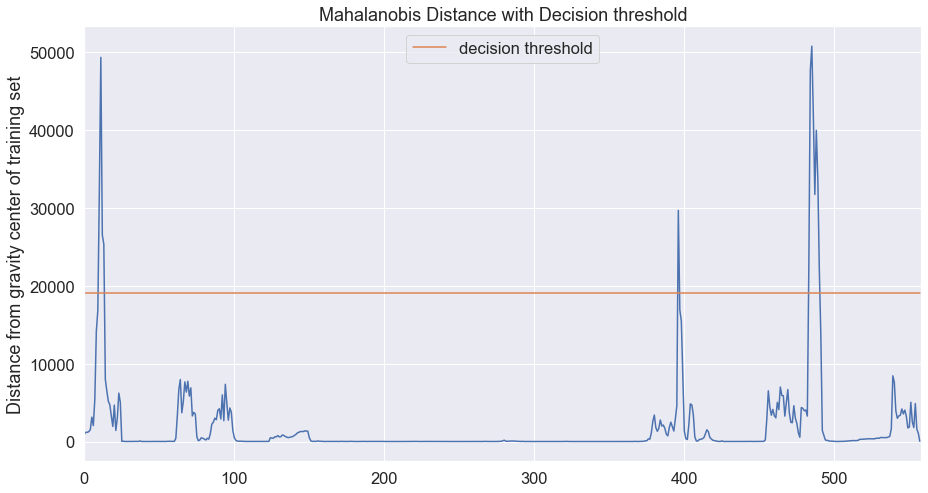

In [20]:
fig = plt.figure(figsize=(15,8))
plt.plot(Mahalanobis_distance)
plt.plot(threshold_mahalanobis  + 0 * Mahalanobis_distance,label='decision threshold')
plt.ylabel('Distance from gravity center of training set')
plt.title('Mahalanobis Distance with Decision threshold')
plt.xlim(0,558)
plt.legend(loc='best')
plt.show()

In [21]:
# Lets take a look at Euclidean distance
# Compute the Euclidean distance of the first 12 principal components

euclidean_distance = np.zeros(normalized_data.shape[0])

for i in range(12):
    euclidean_distance += (principalcomponents[:,i] - np.mean(principalcomponents[:,:12]))**2/np.var(principalcomponents[:,:12])       

In [22]:
euclidean_distance.shape

(558,)

In [23]:
#reconstruct original data from the principal components
#reconstructed_data = projected_data.T @ VT[0:12,:]


#we assume that the data is gaussian so we put a threshold that enusres that at least 99% 
# of our data will be below this value
threshold_euclidean = np.mean(euclidean_distance) + (3 * np.std(euclidean_distance))

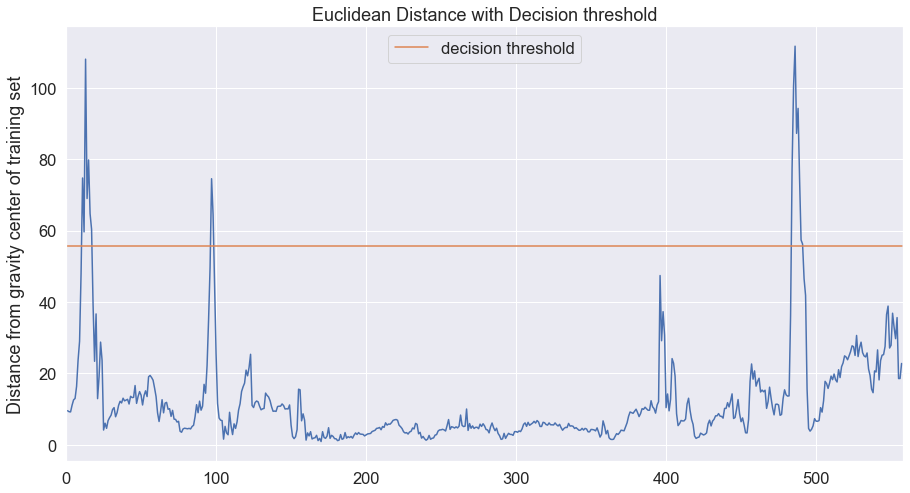

In [24]:
fig = plt.figure(figsize=(15,8))
plt.plot(euclidean_distance)
plt.plot(threshold_euclidean  + 0 * euclidean_distance,label='decision threshold')
plt.ylabel('Distance from gravity center of training set')
plt.title('Euclidean Distance with Decision threshold')
plt.xlim(0,558)
plt.legend(loc='best')
plt.show()

## Fault Detection

In [25]:
# Apply the PCA model on second data set ; Faulty operation
# First normalize the data

from sklearn.preprocessing import StandardScaler

# noramlize the features

standardized_data = StandardScaler().fit_transform(faultyoperation)

In [26]:
standardized_data.shape

(559, 18)

In [27]:
#implement PCA using scikit-learn
pca = PCA()
principalcomponents = pca.fit_transform(standardized_data)

In [28]:
principalDf = pd.DataFrame(data=principalcomponents[:,:2],
                           columns=['principal component 1', 'principal component 2'])
principalDf

,principal component 1,principal component 2
0,-5.213565,3.744599
1,-5.593340,3.445816
2,-5.261560,3.390373
3,-4.748931,4.720355
4,-5.494471,4.219670
...,...,...
554,-3.535830,-0.257209
555,-3.460546,-0.266250
556,-3.518355,-0.332866
557,-3.649392,-0.151862


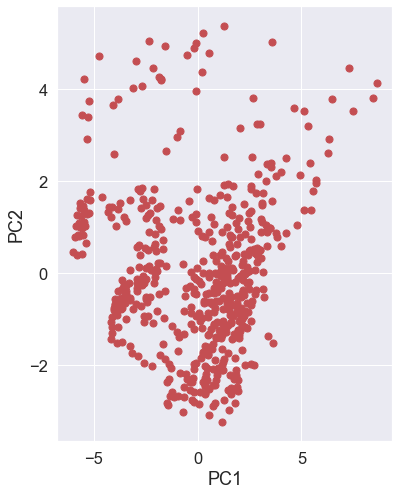

In [29]:
#Visualize 2D projection
fig = plt.figure(figsize=(6,8))
plt.scatter(principalDf['principal component 1'],
            principalDf['principal component 2'],marker='o',color='r',s=50)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()



In [30]:
# Build a fault detection algorithm using Mahalanobis distance based on first
# 12 principal components

from sklearn.covariance import EmpiricalCovariance, MinCovDet

robust_covariance = MinCovDet().fit(principalcomponents[:,:12])

# Get the Mahalanobis distance
Mahalanobis_distance = robust_covariance.mahalanobis(principalcomponents[:,:12])

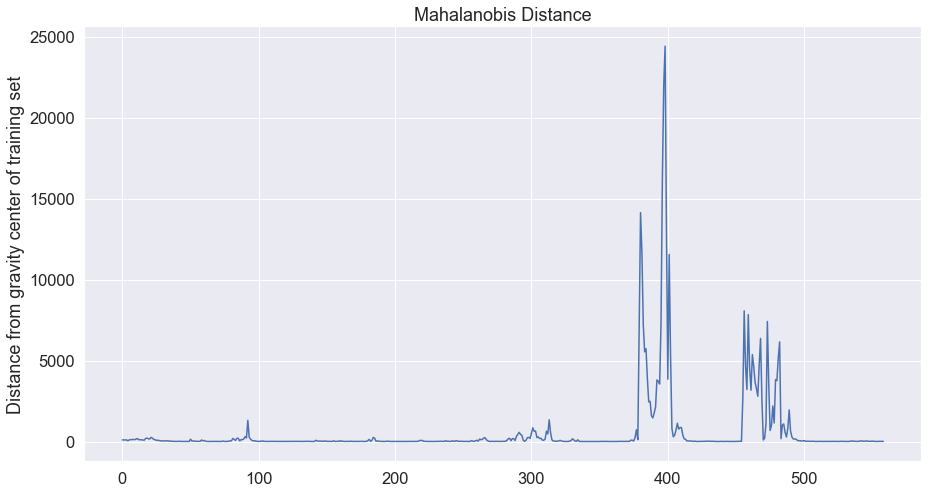

In [31]:
#plot fault detection distance from center threshold
fig = plt.figure(figsize=(15,8))
plt.plot(Mahalanobis_distance)
plt.ylabel('Distance from gravity center of training set')
plt.title('Mahalanobis Distance')
plt.show()

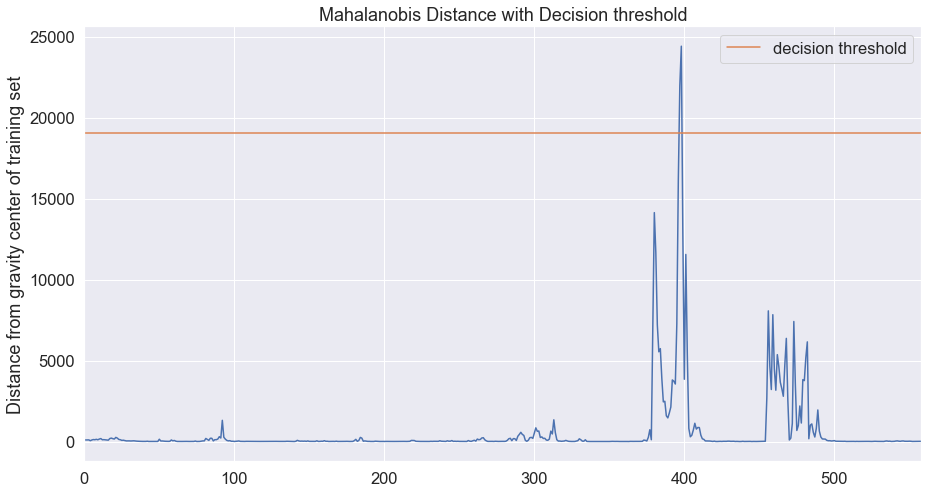

In [32]:
fig = plt.figure(figsize=(15,8))
plt.plot(Mahalanobis_distance)
plt.plot(threshold_mahalanobis  + 0 * Mahalanobis_distance,label='decision threshold')
plt.ylabel('Distance from gravity center of training set')
plt.title('Mahalanobis Distance with Decision threshold')
plt.xlim(0,558)
plt.legend(loc='best')
plt.show()

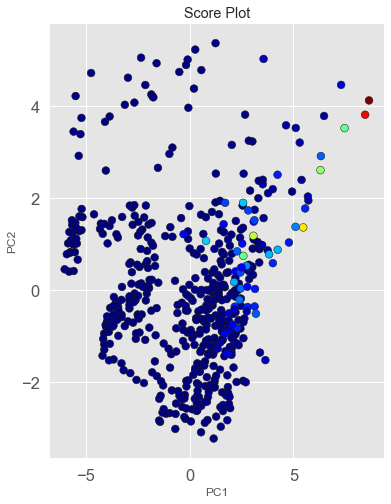

In [33]:
colors = [plt.cm.jet(float(i)/max(Mahalanobis_distance)) for i in Mahalanobis_distance]
fig = plt.figure(figsize=(6,8))
with plt.style.context(('ggplot')):
    plt.scatter(principalDf['principal component 1'],
            principalDf['principal component 2'], c = colors, edgecolors = 'k', s = 60)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('MahaScore Plot')
    plt.show()

In [34]:
# Lets take a look at Euclidean distance
# Compute the Euclidean distance of the first 12 principal components

euclidean_distance = np.zeros(standardized_data.shape[0])

for i in range(12):
    euclidean_distance += (principalcomponents[:,i] - np.mean(principalcomponents[:,:12]))**2/np.var(principalcomponents[:,:12])       

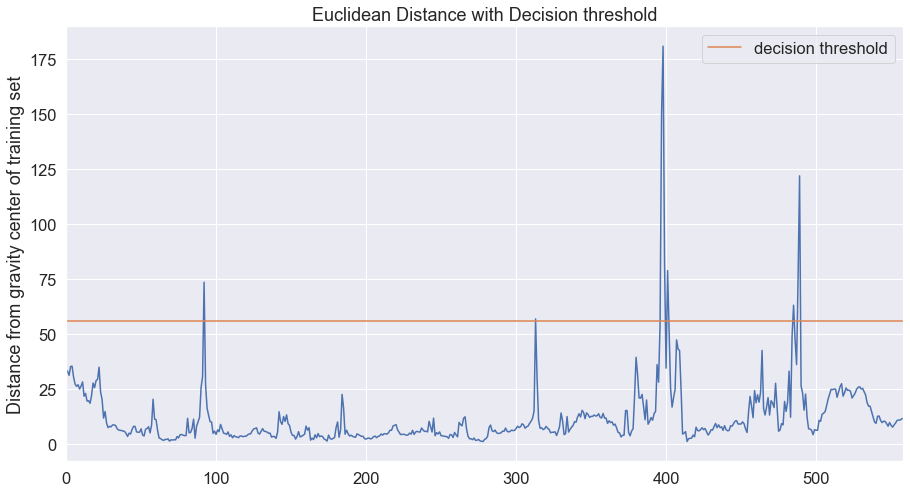

In [35]:
fig = plt.figure(figsize=(15,8))
plt.plot(euclidean_distance)
plt.plot(threshold_euclidean  + 0 * euclidean_distance,label='decision threshold')
plt.ylabel('Distance from gravity center of training set')
plt.title('Euclidean Distance with Decision threshold')
plt.xlim(0,558)
plt.legend(loc='best')
plt.show()